In [8]:
import numpy as np
import matplotlib.pyplot as plt
import tidy3d as td
import tidy3d.web as web 
from tidy3d.plugins.mode import ModeSolver
import gdstk
import scipy.integrate as integrate
from scipy.optimize import fsolve

web.test()

[15:52:41] Authentication configured successfully!                                                    ]8;id=882806;file:///Users/qwang/.pyenv/versions/3.10.11/envs/env_tidy3d/lib/python3.10/site-packages/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=272100;file:///Users/qwang/.pyenv/versions/3.10.11/envs/env_tidy3d/lib/python3.10/site-packages/tidy3d/web/webapi.py#740\740]8;;\

In [12]:
#%matplotlib widget
R_eff = 200  # effective radius of the bend
A = 90  # clothoid parameter
L_max = 0  # starting point of L_max
precision = 1.9  # increasement of L_max at each iteration
tolerance = 1.6  # difference tolerance of the derivatives,if the euler is mess, tune this

# determine L_max
while True:
    L_max = L_max + precision  # update L_max
    Ls = np.linspace(0, L_max, 50)  # L at (x1,y1)
    x1 = np.zeros(len(Ls))  # x coordinate of the clothoid curve
    y1 = np.zeros(len(Ls))  # y coordinate of the clothoid curve

    # compute x1 and y1 using the above integral equations
    for i, L in enumerate(Ls):
        y1[i], err = integrate.quad(lambda theta: A * np.sin(theta**2 / 2), 0, L / A)
        x1[i], err = integrate.quad(lambda theta: A * np.cos(theta**2 / 2), 0, L / A)

    # compute the derivative at L_max
    k = -(x1[-1] - x1[-2]) / (y1[-1] - y1[-2])
    xp = x1[-1]
    yp = y1[-1]
    # check if the derivative is continuous at L_max
    R = np.sqrt(
        ((R_eff + k * xp - yp) / (k + 1) - xp) ** 2
        + (-(R_eff + k * xp - yp) / (k + 1) + R_eff - yp) ** 2
    )
    if np.abs(R - A**2 / L_max) < tolerance:
        break

# after L_max is determined, R_min is also determined
R_min = A**2 / L_max
print(R_min)
print(R)

58.3994232155731
57.488666803478246


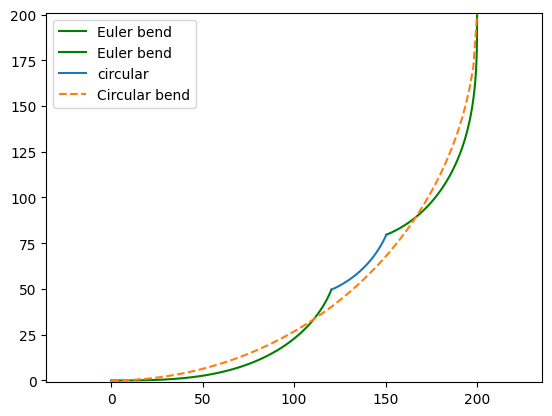

In [13]:

# getting the coordinates of the second clothoid curve by mirroring the first curve with respect to y=-x+R_eff
x3 = np.flipud(R_eff - y1)
y3 = np.flipud(R_eff - x1)


# solve for the parameters of the circular curve
def circle(var):
    a = var[0]
    b = var[1]
    Func = np.empty((2))
    Func[0] = (xp - a) ** 2 + (yp - b) ** 2 - R_min**2
    Func[1] = (R_eff - yp - a) ** 2 + (R_eff - xp - b) ** 2 - R_min**2
    return Func
a, b = fsolve(circle, (0, R_eff))

# calculate the coordinates of the circular curve
x2 = np.linspace(xp + 0.01, R_eff - yp - 0.01, 50)
y2 = -np.sqrt(R_min**2 - (x2 - a) ** 2) + b

# obtain the coordinates of the whole Euler bend by concaten.0ating three pieces together
x_euler = np.concatenate((x1, x2, x3))
y_euler = np.concatenate((y1, y2, y3))

# the conventional circular bend is simply given by a circle
x_circle = np.linspace(0, R_eff, 100)
y_circle = -np.sqrt(R_eff**2 - (x_circle) ** 2) + R_eff

# plotting the shapes of the Euler bend and the circular bend
plt.plot(x1, y1, "g",label="Euler bend")
plt.plot(x3, y3, "g",label="Euler bend")
plt.plot(x2, y2, label="circular")
plt.plot(x_circle, y_circle, "--", label="Circular bend")
plt.axis("equal")
plt.ylim(-1, R_eff + 1)
plt.legend()
plt.show()

In [14]:
lda0 = 1.55  # central wavelength
freq0 = td.C_0 / lda0  # central frequency
ldas = np.linspace(1.54, 1.56, 10)  # simulation wavelength range
freqs = td.C_0 / ldas  # simulation wavelength range
fwidth = 0.5 * (np.max(freqs) - np.min(freqs))  # frequency width of the souce

In [15]:
t = 0.2  # thickness of the waveguide
w = 1.5  # width of the waveguide
inf_eff = 1000  # effective infinity of the simulation
buffer = 1  # buffer distance

n_si = 1.9741  # silicon refractive index
#use siN index instead, but still call it Si
si = td.Medium(permittivity=n_si**2)
n_sio2 = 1.444  # silicon oxide refractive index
sio2 = td.Medium(permittivity=n_sio2**2)


In [16]:
# function that takes the x and y coordinates of a curve and returns a waveguide bend structure with a given width and thickness
def line_to_structure(x, y, w, t):

    cell = gdstk.Cell("bend") # define a gds cell

    # add points to include the input and output straght waveguides
    x = np.insert(x, 0, -inf_eff)
    x = np.append(x, R_eff)
    y = np.insert(y,0,0)
    y = np.append(y, inf_eff)

    cell.add(gdstk.FlexPath(x + 1j * y, w, layer=1, datatype=0)) # add path to cell

    # define structure from cell
    bend = td.Structure(
        geometry=td.PolySlab.from_gds(
            cell,
            gds_layer=1,
            axis=2,
            slab_bounds=(0, t),
        )[0],
        medium=si
    )

    return bend

circular_bend = line_to_structure(x_circle, y_circle, w, t)

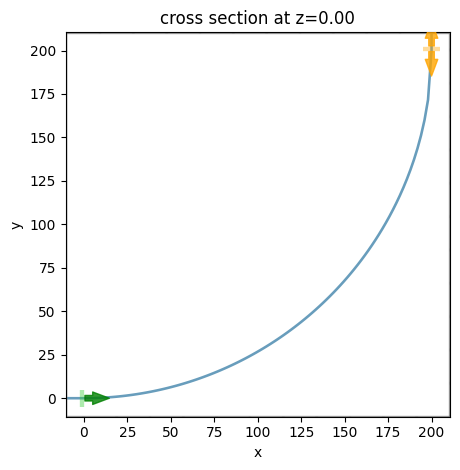

In [17]:

#%matplotlib widget
# add a mode source that launches the fundamental te mode
mode_spec = td.ModeSpec(num_modes=1, target_neff=1.54)

mode_source = td.ModeSource(
    center=(-buffer, 0, t / 2),
    size=(0, 10,8),
    source_time=td.GaussianPulse(freq0=freq0, fwidth=fwidth),
    direction="+",
    mode_spec=mode_spec,
    mode_index=0,
)

# add a mode monitor to measure transmission
mode_monitor = td.ModeMonitor(
    center=(R_eff, R_eff + buffer, t / 2),
    size=(10, 0, 8),
    freqs=freqs,
    mode_spec=mode_spec,
    name="mode",
)


# add a field monitor to visualize field propagation and leakage in the bend
field_monitor = td.FieldMonitor(
    center=(R_eff / 2, R_eff / 2, t / 2),
    size=(td.inf, td.inf, 0),
    freqs=[freq0],
    colocate=True,
    name="field",
)


run_time = 5e-12  # simulation run time

# define simulation
sim = td.Simulation(
    center=(R_eff / 2, R_eff / 2, t / 2),
    size=(R_eff+20, R_eff+20, 8),
    grid_spec=td.GridSpec.auto(min_steps_per_wvl=20, wavelength=lda0),
    structures=[circular_bend],
    sources=[mode_source],
    monitors=[mode_monitor, field_monitor],
    run_time=run_time,
    boundary_spec=td.BoundarySpec.all_sides(
    boundary=td.PML()
    ),  # pml is applied in all boundaries
    medium=sio2,
)  # background medium is set to sio2 because of the substrate and upper cladding

# visualize the circular bend structure
sim.plot(z=0)
#plt.xlim(155, 162)


#sim.plot(x=-1)
#sim.plot(y=5)
plt.show()

In [38]:
mode_source = mode_source.copy(update={"mode_index": 0})  # mode_index=1 corresponds to the TM0 mode

mode_solver = ModeSolver(
    simulation=sim,
    plane=td.Box(center=(-buffer, 0, t / 2), size=(0, 10, 8)),
    mode_spec=mode_spec,
    freqs=[freq0],
)
mode_data = mode_solver.solve()

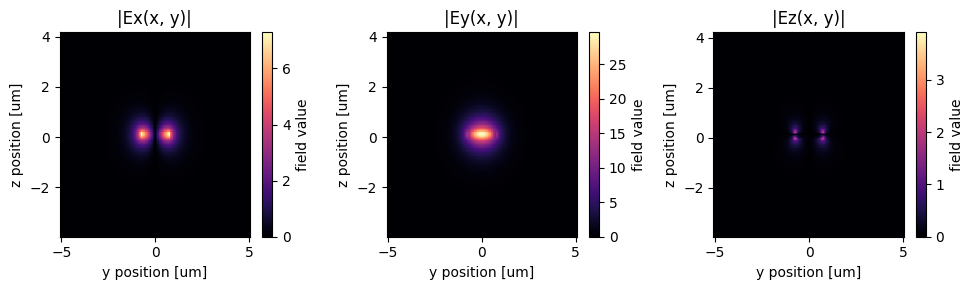

In [9]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, tight_layout=True, figsize=(10, 3))
abs(mode_data.Ex.isel(mode_index=0)).plot(x="y", y="z", ax=ax1, cmap="magma")
abs(mode_data.Ey.isel(mode_index=0)).plot(x="y", y="z", ax=ax2, cmap="magma")
abs(mode_data.Ez.isel(mode_index=0)).plot(x="y", y="z", ax=ax3, cmap="magma")

ax1.set_title("|Ex(x, y)|")
ax2.set_title("|Ey(x, y)|")
ax3.set_title("|Ez(x, y)|")
plt.show()

In [51]:
mode_solver = ModeSolver(
    simulation=sim,
    plane=td.Box(center=(R_eff, R_eff + buffer, t / 2), size=(10, 0, 8)),
    mode_spec=mode_spec,
    freqs=[freq0],
)

mode_data = mode_solver.solve()

f, (ax1, ax2, ax3) = plt.subplots(1, 3, tight_layout=True, figsize=(10, 3))
abs(mode_data.Ex.isel(mode_index=0)).plot(x="x", y="z", ax=ax1, cmap="magma")
abs(mode_data.Ey.isel(mode_index=0)).plot(x="x", y="z", ax=ax2, cmap="magma")
abs(mode_data.Ez.isel(mode_index=0)).plot(x="x", y="z", ax=ax3, cmap="magma")

ax1.set_title("|Ex(x, y)|")
ax2.set_title("|Ey(x, y)|")
ax3.set_title("|Ez(x, y)|")
plt.show()

ValidationError: 1 validation error for ModeSolver
mode_index
  extra fields not permitted (type=value_error.extra)

In [12]:
job = web.Job(simulation=sim, task_name="circular_bend")
sim_data_circular = job.run(path="data/simulation_data_circular.hdf5")


[11:55:18] Created task 'circular_bend' with task_id 'fdve-74993da2-5035-414f-a9c4-db535adeda32v1'.   ]8;id=77145;file:///Users/qwang/.pyenv/versions/3.10.11/envs/env_tidy3d/lib/python3.10/site-packages/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=277671;file:///Users/qwang/.pyenv/versions/3.10.11/envs/env_tidy3d/lib/python3.10/site-packages/tidy3d/web/webapi.py#186\186]8;;\

           View task using web UI at                                                                  ]8;id=751840;file:///Users/qwang/.pyenv/versions/3.10.11/envs/env_tidy3d/lib/python3.10/site-packages/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=400179;file:///Users/qwang/.pyenv/versions/3.10.11/envs/env_tidy3d/lib/python3.10/site-packages/tidy3d/web/webapi.py#188\188]8;;\
           ]8;id=281366;https://tidy3d.simulation.cloud/workbench?taskId=fdve-74993da2-5035-414f-a9c4-db535adeda32v1\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=934307;https://tidy3d.simulation.cloud/workbench?taskId=fdve-74993da2-5035-414f-a9c4-db535adeda32v1\taskId]8;;\]8;id=281366;https://tidy3d.simulation.cloud/workbench?taskId=fdve-74993da2-5035-414f-a9c4-db535adeda32v1\=]8;;\]8;id=95701;https://tidy3d.simulation.cloud/workbench?taskId=fdve-74993da2-5035-414f-a9c4-db535adeda32v1\fdve]8;;\]8;id=281366;https://tidy3d.simulation.cloud/workbench?taskId=fdve-74993da2-5035-414f-a9c4-db535adeda32v1\-74993da2-5035-414f-a9c4-db535adeda3]8;;\              
           ]8;id=281366;https://tidy3d.simulation.cloud/workbench?taskId=fdve-74993da2-5035-414f-a9c4-db535adeda32v1\2v1']8;;\.                                                                                                   

Output()

[11:55:19] status = queued                                                                            ]8;id=158485;file:///Users/qwang/.pyenv/versions/3.10.11/envs/env_tidy3d/lib/python3.10/site-packages/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=345414;file:///Users/qwang/.pyenv/versions/3.10.11/envs/env_tidy3d/lib/python3.10/site-packages/tidy3d/web/webapi.py#321\321]8;;\

Output()

[11:55:21] status = preprocess                                                                        ]8;id=366101;file:///Users/qwang/.pyenv/versions/3.10.11/envs/env_tidy3d/lib/python3.10/site-packages/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=506176;file:///Users/qwang/.pyenv/versions/3.10.11/envs/env_tidy3d/lib/python3.10/site-packages/tidy3d/web/webapi.py#315\315]8;;\

[11:55:35] Maximum FlexCredit cost: 39.485. Use 'web.real_cost(task_id)' to get the billed FlexCredit ]8;id=444443;file:///Users/qwang/.pyenv/versions/3.10.11/envs/env_tidy3d/lib/python3.10/site-packages/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=336546;file:///Users/qwang/.pyenv/versions/3.10.11/envs/env_tidy3d/lib/python3.10/site-packages/tidy3d/web/webapi.py#338\338]8;;\
           cost after a simulation run.                                                                            

           starting up solver                                                                         ]8;id=840772;file:///Users/qwang/.pyenv/versions/3.10.11/envs/env_tidy3d/lib/python3.10/site-packages/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=575686;file:///Users/qwang/.pyenv/versions/3.10.11/envs/env_tidy3d/lib/python3.10/site-packages/tidy3d/web/webapi.py#342\342]8;;\

           running solver                                                                             ]8;id=965375;file:///Users/qwang/.pyenv/versions/3.10.11/envs/env_tidy3d/lib/python3.10/site-packages/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=612468;file:///Users/qwang/.pyenv/versions/3.10.11/envs/env_tidy3d/lib/python3.10/site-packages/tidy3d/web/webapi.py#352\352]8;;\

Output()

: 

In [50]:
sim_data_circular = web.load(path="data/simulation_data_circular.hdf5")


TypeError: load() missing 1 required positional argument: 'task_id'

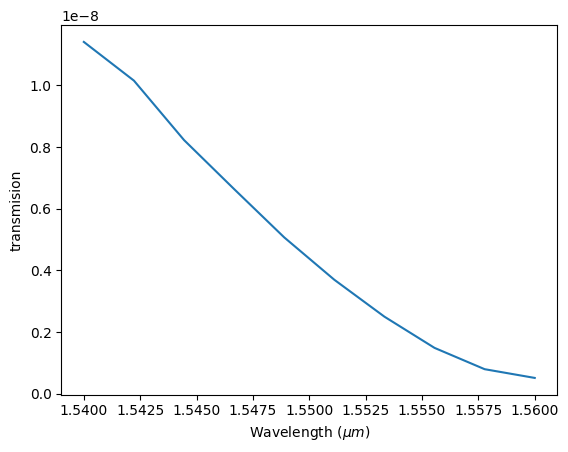

In [49]:
# extract the transmission data from the mode monitor

amp = sim_data_circular["mode"].amps.sel(mode_index=0, direction="+")
T_circular = np.abs(amp)**2

# plot the bending loss as a function of wavelength
plt.plot(ldas, (T_circular))
#plt.plot(ldas, -10 * np.log10(T_circular))
#plt.xlim(1.5, 1.6)
#plt.ylim(0, 0.03)
plt.xlabel("Wavelength ($\mu m$)")
plt.ylabel("transmision")
#plt.ylabel("Bending loss (dB)")
plt.show()


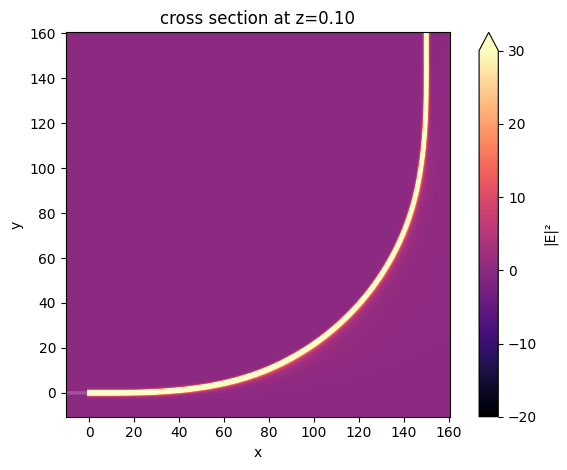

In [33]:
sim_data_circular.plot_field(
    field_monitor_name="field",
    field_name="E",
    val="abs^2",
    #scale="dB",
    vmin=-20,
    vmax=30,
)
plt.show()


Loss of an Euler Bend

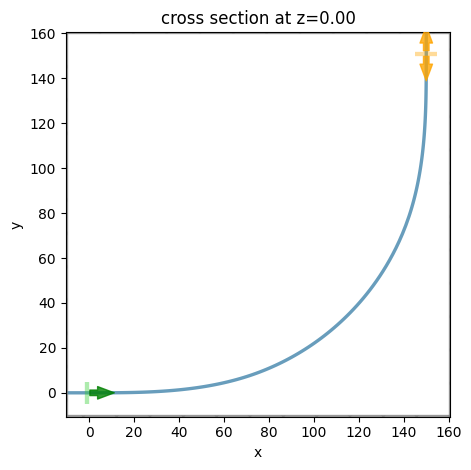

In [11]:
# create the euler waveguide bend structure
euler_bend = line_to_structure(x_euler, y_euler, w, t)

# construct the simulation by copying the previous simulation and updating the structure
sim = sim.copy(update={"structures": [euler_bend]})

# visualize the euler bend structure
sim.plot(z=0)
plt.show()


In [ ]:
job = web.Job(simulation=sim, task_name="circular_bend")
sim_data_euler = job.run(path="data/simulation_data_euler.hdf5")


In [ ]:
# extract the transmission data from the mode monitor
amp = sim_data_euler["mode"].amps.sel(mode_index=0, direction="+")
T_euler = np.abs(amp)**2

# plotting the losses
plt.plot(ldas, -10 * np.log10(T_circular), label="Circular bend")
plt.plot(ldas, -10 * np.log10(T_euler), label="Euler bend")
plt.xlim(1.5, 1.6)
#plt.ylim(0, 0.03)
plt.xlabel("Wavelength ($\mu m$)")
plt.ylabel("Bending loss (dB)")
plt.legend()
plt.show()


In [ ]:
sim_data_euler.plot_field(
    field_monitor_name="field",
    field_name="E",
    val="abs",
    scale="dB",
    vmin=-20,
    vmax=30,
)
plt.show()
